#Idea
idea use clip to obtain features

# Hyperparameters

In [62]:
BATCH_SIZE=8#  8 for 13.8 gb usage, 6 for less than 12 gb usage
NUM_CLASSES=27

CLIP_FEATURE_SIZE=768

train_percentage=0.80
test_percentage=0.10
valid_percentage=0.10

use_description=False

# Imports


In [63]:
from transformers import CLIPProcessor, CLIPModel,CLIPFeatureExtractor
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision

import imageio

from tqdm.auto import tqdm # for cool loading bar
from keras.utils import to_categorical


from sklearn.metrics import f1_score

import zipfile
import os
import copy

import matplotlib.pyplot as plt


In [64]:
# mount the drive where your dataset is availabledevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')
filepath='/content/drive/MyDrive/datasets/multimodal_product_classification/' # add your own path. Where to save the dataset

if not os.path.exists('datasets'):
  os.makedirs('datasets')
  with zipfile.ZipFile(filepath+'images.zip', 'r') as zip_ref:
      zip_ref.extractall('datasets')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Preprocessing

In [66]:
# Load data
X_train = pd.read_csv(filepath+'X_train.csv').fillna("")
y_train = pd.read_csv(filepath+'Y_train.csv').fillna("")
X_train=X_train.drop(columns="Unnamed: 0")
y_train=y_train.drop(columns="Unnamed: 0")


In [67]:
description_len=[len(x) for x in X_train['description'].tolist()]

(array([7.4796e+04, 8.1160e+03, 1.3860e+03, 3.5100e+02, 1.6100e+02,
        6.5000e+01, 2.5000e+01, 1.3000e+01, 2.0000e+00, 1.0000e+00]),
 array([    0. ,  1245.1,  2490.2,  3735.3,  4980.4,  6225.5,  7470.6,
         8715.7,  9960.8, 11205.9, 12451. ]),
 <BarContainer object of 10 artists>)

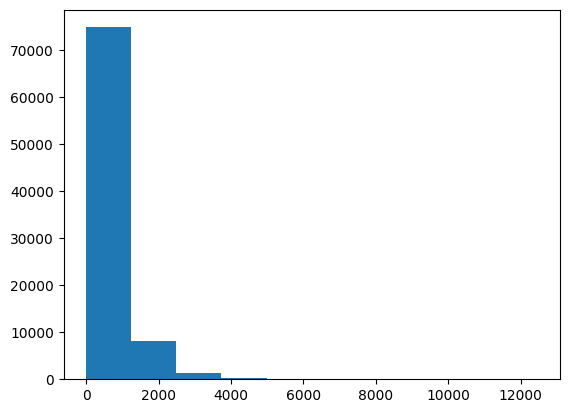

In [68]:
plt.hist(description_len)

Most of description have less than 4000 len,
maybe in the future  slice at 4000 for not too long tokenization

In [69]:
# Apply cleaning function to the 'designation' column
def clip_to_max_tokenize(text):
    text.split(" ",maxsplit=70)
    text=text[:70]
    text="".join(text)
    return(text)

X_train['designation'] = X_train['designation'].fillna('').apply(clip_to_max_tokenize)
X_train['description'] = X_train['description'].fillna('').apply(clip_to_max_tokenize)


In [70]:
y_train=y_train["prdtypecode"].to_numpy()
# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)


In [71]:
y_train=pd.DataFrame(y_train,columns=["labels"])

In [72]:
train_df=pd.concat([X_train,y_train],axis=1)

In [73]:
train_df

,designation,description,productid,imageid,labels
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705
...,...,...,...,...,...
84911,The Sims [ Import Anglais ],,206719094,941495734,40
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,2583
84913,Journal Officiel De La Republique Francaise N°...,,440707564,1009325617,2280
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,1560



# Data loading

In [74]:
def image_to_tensor(image):
    img=torch.from_numpy(image).float()
    out=img.permute(2,0,1)
    return(out)

In [75]:
class ImageTextDataLoader(Dataset):
    """Title, Description and Image dataset."""

    def __init__(self, dataframe, image_dir):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
        """
        self.df = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        selected_df=self.df.iloc[idx]

        image_name="image_"+str(selected_df["imageid"])+"_product_"+str(selected_df["productid"])+".jpg"
        filepath=os.path.join(self.image_dir,image_name)
        image_arr = imageio.v3.imread(filepath)

        designation=selected_df['designation']
        description=selected_df['description']
        label=selected_df['labels']

        return [designation,description,image_arr,label]


In [76]:
dataset=ImageTextDataLoader(train_df,"/content/datasets/images/image_train")


In [77]:
train_size = int(train_percentage * len(dataset))
valid_size = int(test_percentage * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


dataloaders={
    'train':train_dataloader,
    'val':valid_dataloader,
    'test':test_dataloader
    }


In [78]:
Clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
Clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [79]:
def get_images_features(images):
    inputs = Clip_processor(images=images, return_tensors="pt").to(device)
    image_features = Clip_model.get_image_features(**inputs).to(device)
    del inputs
    return(image_features)

def get_text_features(texts):
    inputs = Clip_processor(text=texts, padding=True, return_tensors="pt").to(device)
    text_features = Clip_model.get_text_features(**inputs).to(device)
    del inputs
    return(text_features)

# Model Definition

way 0 : concat the layer
way 1 (future): cross modal concatenation

In [80]:
print(Clip_model.device)

cpu


In [81]:
class ClassificationHead(nn.Module):
   def __init__(self, input_dim, num_classes):
       super(ClassificationHead, self).__init__()

       self.head=nn.Sequential(
            nn.Linear(input_dim,128),
            nn.ReLU(),
            nn.Linear(128,num_classes),
       )
       #self.softmax = nn.Softmax(dim=-1)

   def forward(self, x):
       x = self.head(x)
       return (x)


In [82]:
model=ClassificationHead(3*CLIP_FEATURE_SIZE,NUM_CLASSES).to(device)

criterion = torch.nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [83]:
def calculate_weighted_f1_score(y_true, y_pred):
  return f1_score(y_true, y_pred, average='weighted')

In [84]:
def plot_loss(train_losses,val_losses):
  plt.figure(1,figsize=(12, 6))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()



In [85]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_losses = {'train': [], 'val': []}
    epoch_accs = {'train': [], 'val': []}
    epoch=0
    loop_on_epoch=tqdm(range(num_epochs))
    for epoch in loop_on_epoch:
        loop_on_epoch.set_description("Train -> Loss: {:.4f} Acc: {:.4f} | Val -> {:.4f} Acc: {:.4f}".format(epoch_losses["train"][-1],epoch_accs["train"][-1],epoch_losses["val"][-1],epoch_accs["val"][-1])if epoch>=1 else "first epoch")
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_preds=np.array([])
            running_labels=np.array([])


            # Iterate over data.
            loop_on_batch=tqdm(dataloaders[phase])
            for designation,description,image_arr,labels in loop_on_batch:
                print(designation)
                designation = designation
                description = description
                image_arr.to(device)

                with torch.no_grad():
                    images_features=get_images_features(image_arr)
                    designation_features=get_text_features(designation)
                    description_features=get_text_features(description)

                #HERE implement fusion model of designation, description and image_arr
                    input_features=torch.cat([images_features,designation_features,description_features])


                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(input_features)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * designation.size(0)#batch size*actual loss
                running_preds=np.append(running_preds,preds.cpu().numpy())
                running_labels=np.append(running_labels,labels.data.cpu().numpy())
                loop_on_batch.set_description('{}| Loss: {:.4f}'.format(phase, loss.item()))


            #End of phase Epoch (train or validation)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc=calculate_weighted_f1_score(running_preds,running_labels)

            epoch_losses[phase]=np.append(epoch_losses[phase],epoch_loss)
            epoch_accs[phase]=np.append(epoch_accs[phase],epoch_acc)

            if phase == 'train':
                scheduler.step()

        #End of Epoch (train+validation epoch)
        plot_loss(epoch_losses["train"],epoch_losses["val"])#plot the loss at each epoch

        if epoch==10: #Unfreeze the model after the 10th epoch
            for param in model.parameters():
                param.requires_grad = True
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:

            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), '/content/drive/MyDrive/Lessons/Models/multimodal_classification/' + 'Resnet16-best'+str(epoch)+'.ckpt')


        plot_loss(epoch_losses["train"],epoch_losses["val"])#plot the loss at each epoch

    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_losses, epoch_accs

In [86]:
train_model(model, criterion, optimizer,exp_lr_scheduler,num_epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8492 [00:00<?, ?it/s]

("Grande Fontaine À Poser Colonne En Fonte D'aluminium Patinée Marron Av", "Régulateur de pH OPTI'pH AOA", 'Aspiration pour Kit Jet NCB - liner de Espa - Accessoires NCC', 'Mignon Mochi Chat Pincez Guérison Fun Enfants Kawaii Toy Remède Contre', 'Xt-2 Caméra Hd Pliable Rc Drone Wifi 30w Pocket Drone Selfie Fold De L', 'Les Inrockuptibles 1001 / François Morel - Chris Esquerre - Mila Kunis', 'Raspoutine À Cheval / La Cour Secrète Des Arcanes : Boîte N°3', 'Soldats De Plomb 26° Régiment De Cavalerie Us 1942')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (24x768 and 2304x128)